## Data Loading

In [91]:
import pandas as pd

df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [92]:
df.shape

(1190, 12)

## Data Cleaning

In [93]:
print(df.duplicated().sum())

272


In [94]:
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

0


In [95]:
df.shape

(918, 12)

## Data Splitting

In [96]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :11]
Y = df.iloc[:, 11]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [97]:
Y_test.value_counts()

target
1    164
0    112
Name: count, dtype: int64

## Feature Scaling

In [98]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.gz')
print('Scaler saved as scaler.gz')

Scaler saved as scaler.gz


## Data Shape

In [99]:
print(f'Training data input shape : {X_train.shape}')
print(f'Testing data input shape  : {X_test.shape}')

Training data input shape : (642, 11)
Testing data input shape  : (276, 11)


## Model Building (Deep Neural Network)

In [100]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense

def DNN_Model(input_shape):
    input = Input(shape=input_shape)
    
    x = Dense(256, activation='relu')(input)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input, outputs=output)    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['recall'])
    return model

input_shape = (X_train.shape[1],)
model = DNN_Model(input_shape)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,257 (188.50 KB)

 Trainable params: 47,297 (184.75 KB)

 Non-trainable params: 960 (3.75 KB)

## Model Training

In [101]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('DNN_Model.keras', monitor='val_recall', save_best_only=True, mode='max', verbose=1)

print('✅ Starting CNN-GRU Hybrid Deep Learning Model Training....\n')
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), callbacks=[early_stop, checkpoint], verbose=1)
print("\n✅ Model Training Completed. Best model saved as 'DNN_Model.keras'")

✅ Starting CNN-GRU Hybrid Deep Learning Model Training....

Epoch 1/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.9055 - recall: 0.3077
Epoch 1: val_recall improved from None to 0.96951, saving model to DNN_Model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5408 - recall: 0.7645 - val_loss: 0.5949 - val_recall: 0.9695
Epoch 2/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4262 - recall: 1.0000
Epoch 2: val_recall did not improve from 0.96951
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4093 - recall: 0.8547 - val_loss: 0.5393 - val_recall: 0.9695
Epoch 3/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4736 - recall: 0.8571
Epoch 3: val_recall improved from 0.96951 to 0.97561, saving model to DNN_Model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3964 - recall: 0.8605 - val_loss: 0.5127 - val_recall: 0.9756
Epoch 4/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3925 - recall: 0.8333
Epoch 4: val_recall did not improve from 0.97561
21/21 ━━

## Model Testing and Model Evaluation

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Y_pred_train_prob = model.predict(X_train, verbose=1)
Y_pred_test_prob = model.predict(X_test, verbose=1)

Y_pred_train = (Y_pred_train_prob > 0.5).astype(int)
Y_pred_test = (Y_pred_test_prob > 0.5).astype(int)

print("\n🟧 ----- Train Metrics -----")
print(f"Accuracy  : {accuracy_score(Y_train, Y_pred_train):.4f}")
print(f"Precision : {precision_score(Y_train, Y_pred_train):.4f}")
print(f"Recall    : {recall_score(Y_train, Y_pred_train):.4f}")
print(f"F1-Score  : {f1_score(Y_train, Y_pred_train):.4f}")

print("\n🟦 ----- Test Metrics -----")
print(f"Accuracy  : {accuracy_score(Y_test, Y_pred_test):.4f}")
print(f"Precision : {precision_score(Y_test, Y_pred_test):.4f}")
print(f"Recall    : {recall_score(Y_test, Y_pred_test):.4f}")
print(f"F1-Score  : {f1_score(Y_test, Y_pred_test):.4f}")

print("\n---------------------------------")
print("Confusion Matrix (Test Set):")
print(confusion_matrix(Y_test, Y_pred_test))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

🟧 ----- Train Metrics -----
Accuracy  : 0.9315
Precision : 0.9144
Recall    : 0.9622
F1-Score  : 0.9377

🟦 ----- Test Metrics -----
Accuracy  : 0.9094
Precision : 0.9427
Recall    : 0.9024
F1-Score  : 0.9221

---------------------------------
Confusion Matrix (Test Set):
[[103   9]
 [ 16 148]]


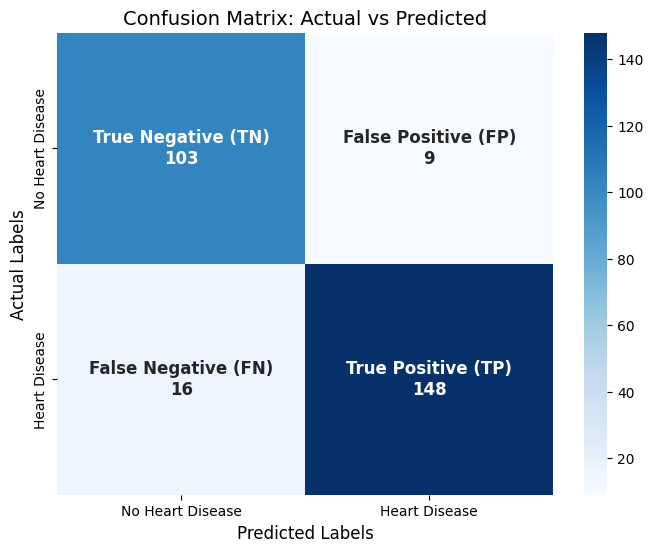

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(Y_test, Y_pred_test)
class_names = ['No Heart Disease', 'Heart Disease']
tn, fp, fn, tp = cm.ravel()
labels = [f'True Negative (TN)\n{tn}', f'False Positive (FP)\n{fp}', f'False Negative (FN)\n{fn}', f'True Positive (TP)\n{tp}']
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12, "weight": "bold"})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)
plt.title('Confusion Matrix: Actual vs Predicted', fontsize=14)
plt.show()

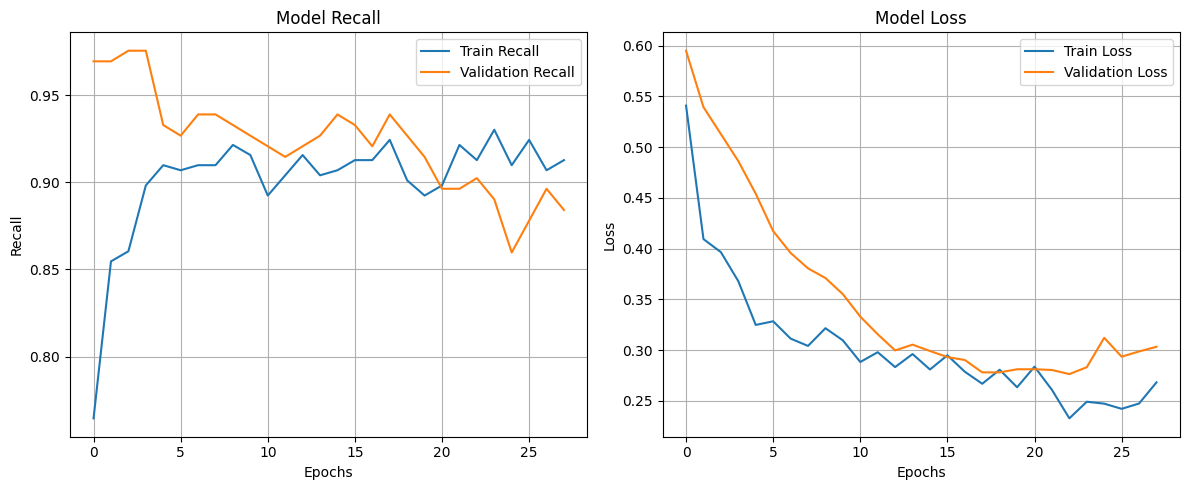

In [104]:
plt.figure(figsize=(12, 5))

# 1. Plot Recall
plt.subplot(1, 2, 1)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# 2. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

input_file = 'heart_statlog_cleveland_hungary_final.csv'
df_full = pd.read_csv(input_file)

X_full = df_full.iloc[:, :11].values

scaler = joblib.load('scaler.gz')
X_full_scaled = scaler.transform(X_full)

model = load_model('DNN_Model.keras')

print("Generating predictions for the full dataset...")
predictions_prob = model.predict(X_full_scaled, verbose=1)
predictions_class = (predictions_prob > 0.5).astype(int).flatten()

df_full['Predicted_Probability'] = predictions_prob
df_full['Predicted_Class'] = predictions_class

output_file = 'heart_disease_with_predictions.csv'
df_full.to_csv(output_file, index=False)

print(f"\n✅ Predictions saved successfully to: {output_file}")
print(df_full[['target', 'Predicted_Class', 'Predicted_Probability']].head())

d:\Predictor_Applications v1.2\Heart_Disease_Risk_Predictor v1.0\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generating predictions for the full dataset...
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

✅ Predictions saved successfully to: heart_disease_with_predictions.csv
   target  Predicted_Class  Predicted_Probability
0       0                0               0.350317
1       1                1               0.523813
2       0                0               0.452750
3       1                1               0.689764
4       0                0               0.414742
